# <div align="center"><b> Trabajo Final - Visión por computadora 2  - CEIA </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomndado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al sigiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-ceia/blob/----.ipynb">----</a></font></small></em> </div> 

<!-- TODO: Arreglar el link -->


* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1tUnWeK372o_yu0LxkMwtC4IR2jorDipN" width="600" alt="Figura 1: Detección de palmeras mediante modelos de aprendizaje profundo."></div> -->

<div align="center"><img src="./resources/portada.jpeg" width="600" alt="Figura 1: Detección de palmeras mediante modelos de aprendizaje profundo."></div>

<div align="center"><small><em>Figura 1: Detección de palmeras mediante modelos de aprendizaje profundo.</em></small></div>

<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Trabajo final - VPC2 - FIUBA                                                                                                           |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Palm tree detector                                                                                                                     |
| **Integrantes** | - Bruno Masoller (brunomaso1@gmail.com) </br> - Simón Rodriguez (simon.andre.r@gmail.com)                                              |

</div>

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

*Inicialmente, se descargan varios datos desde Google Drive. Los archivos descargados constan de las carpetas `datasets` y `utils`. En la carpeta `datasets` se encuentran los conjuntos de datos y en la carpeta `utils`, utilidades necesarias, como archivos auxiliares que facilitan la visualización y entrenamiento del modelo.*

In [169]:
# Librerías básicas para el tratamiento de archivos del sistema y procesamiento aleatorio.
import sys, os, warnings, zipfile, shutil , random

# Librería para TypesHint.
from typing import List, Tuple, Dict, Union
from enum import Enum

# Librería para el procesamiento numérico.
import numpy as np

# Librería para procesamiento de gráficas.
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Librería de deeplearning de pytorch y su análogo para visión por computadora.
import torch, torchvision 

# Utilidades de pytorch.
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Utilidades de torchvision.
from torchvision.transforms import functional as F
from torchvision.transforms import v2 as T
from torchvision.io import read_image
from torchvision import tv_tensors

# Librería para procesamiento de archivos XML.
import xml.etree.ElementTree as ET

# Librería de utilizadades para el procesamiento de visión por computadora.
import cv2

# Librería para visualiación de Datasets.
import fiftyone as fo

# Librería que permite ver el resumen de un modelo de deeplearning.
from torchinfo import summary

# Configuraciónes previas.
DOWNLOAD_RESOURCES = False # Permite indicar si descargar el conjunto o no
RUTA_CARPETA_RESOURCES = './resources'
RUTA_ARCHIVO_REQUERIMIENTOS = os.path.join(RUTA_CARPETA_RESOURCES, 'requirements.txt')
RUTA_CARPETA_UTILS = os.path.join(RUTA_CARPETA_RESOURCES, 'utils')

# Esta lógica descarga los recursos necesarios para este proyecto desde Google Drive.
# Si no está disponible el link, se puede acceder desde:
# - Dataset Palmeras: https://www.kaggle.com/datasets/riotulab/aerial-images-of-palm-trees
# - Utilidades de torchvision: https://github.com/pytorch/vision/tree/main/references/detection
if DOWNLOAD_RESOURCES:
    print("Descargando recursos...")
    %pip install gdown
    !gdown https://drive.google.com/drive/folders/1DFfgoGQ8-zLwQU85Uyq0X72GX4IITInV?usp=sharing --folder

# Verificamos si la carpeta ha sido descargada correctamente
if os.path.exists(RUTA_CARPETA_RESOURCES):
    print(f"La carpeta {RUTA_CARPETA_RESOURCES} fue encontrada.")

    # Verificamos si el archivo de requerimientos existe
    if os.path.exists(RUTA_ARCHIVO_REQUERIMIENTOS):
        print("Archivo de requerimientos encontrado, instalando dependencias...")
        %pip install -r {RUTA_ARCHIVO_REQUERIMIENTOS}
    else:
        warnings.warn(f"El archivo {RUTA_ARCHIVO_REQUERIMIENTOS} no fue encontrado. No se instalarán los requerimientos.")

    if os.path.exists(RUTA_CARPETA_UTILS):
        # Se agrega esta ruta al path para que funcionen las utilidades de pytorch.
        sys.path.append(os.path.abspath('./resources/utils'))
        print(f"Se agregó la ruta {RUTA_CARPETA_UTILS} al system path.")
    else:
        raise FileNotFoundError(f"La carpeta {RUTA_CARPETA_UTILS} no fue encontrada. Verifique la descarga.")
else:
    raise FileNotFoundError(f"La carpeta {RUTA_CARPETA_RESOURCES} no fue encontrada. Verifique la descarga.")

# Librería de utilidades de pytorchvision/detection.
from engine import train_one_epoch, evaluate # type: ignore

La carpeta ./resources fue encontrada.
Archivo de requerimientos encontrado, instalando dependencias...
Note: you may need to restart the kernel to use updated packages.
Se agregó la ruta ./resources\utils al system path.


🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [206]:
VERBOSE = True # Muestra época a época la evolución
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Establece el dispositivo.
RANDOM_SEED = 42
EPOCHS = 100 # Cantidad de épocas genéricas a entrenar.
BATCH_SIZE = 64 # Tamaño de batch genérico.

# Datasets:
PALMERAS_KAGGLE_DATASET_VOC = 'palmeras_kaggle_voc_format'
PALMERAS_KAGGLE_DATASET_COCO = 'palmeras_kaggle_coco_format'

# Rutas:
RUTA_CARPETA_COMPRESSED = os.path.join(RUTA_CARPETA_RESOURCES, 'datasets', 'compressed')
RUTA_CARPETA_RAW = os.path.join(RUTA_CARPETA_RESOURCES, 'datasets', 'raw')

RUTA_CARPETA_KAGGLE_DATASET_VOC = os.path.join(RUTA_CARPETA_RAW, PALMERAS_KAGGLE_DATASET_VOC)
RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA = os.path.join(RUTA_CARPETA_KAGGLE_DATASET_VOC, "data")
RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS = os.path.join(RUTA_CARPETA_KAGGLE_DATASET_VOC, "labels")

RUTA_CARPETA_KAGGLE_DATASET_COCO = os.path.join(RUTA_CARPETA_RAW, PALMERAS_KAGGLE_DATASET_COCO)

# Configuraciones de imágenes:
FORMATOS_IMAGENES = ('.jpg', '.jpeg', '.png')
FORMATOS_LABELS = ('.xml')
IMG_SIZE_W, IMG_SIZE_H = 1000, 1000 # TODO: Usar esto

# Etiquetas:
LABELS = {
    'Palm' : 1
}

TRAIN_TEST_SPLIT_RATIO = [0.8, 0.2]

random.seed(RANDOM_SEED)

print(f'Dispositivo actual: {DEVICE}')

Dispositivo actual: cpu


## Introduction

<em><p>

En el marco de la especialización en Inteligencia Artificial de la Facultad de Ingeniería de la Universidad de Buenos Aires, se plantea, como trabajo final de la materia Visión por Computadora 2, se tiene como objetivo desarrollar un modelo de visión por computadora que utilice aprendizaje profundo para detectar ubicaciones de palmeras en diversas imágenes áereas.

Metodológicamente, se aplican principios de [CRISP-ML(Q)](https://ml-ops.org/content/crisp-ml) para el desarrollo del problema.

</p></em>

## Business and data understanding

<em><p>

La detección de palmeras es ampliamente estudiado en el área de visión por computadora, dado su potencial como insumo de otras soluciones, como por ejemplo, aquellas que intentan mejorar la salud de las palmeras, donde inicalmente es deseable una detección aera para luego realizar una inspección manual (con el objetivo de reducir costos).

Muchos estudios (como [este](https://www.researchgate.net/publication/382742087_Implementation_of_Slicing_Aided_Hyper_Inference_SAHI_in_YOLOv8_to_Counting_Oil_Palm_Trees_Using_High-Resolution_Aerial_Imagery_Data) por ejemplo) se realizan en paises en donde la mayoría de las palmeras son materia prima para la producción del "aceite de palmera". Sin embargo, en paises no productores, el cuidado de las palmeras también es importante, dado su impacto en el medio ambiente. 

</p></em>

## Data preparation

*Los datos fueron obenidos del sito de Kaggle: https://www.kaggle.com/datasets/riotulab/aerial-images-of-palm-trees, sin embargo, para una mejor manejo, se los importan desde Google Drive (https://drive.google.com/drive/folders/1DFfgoGQ8-zLwQU85Uyq0X72GX4IITInV).*

### Data pre-processing

*Luego de descargado los datos, tenemos la siguiente estructura de directorios:*

<!-- https://tree.nathanfriend.io/
- resources
  - datasets
    - compressed
      - palmeras_kaggle.zip
  - utils
    - engine.py
    - train.py
    - ...
 -->

<em><p>

<pre>
resources
├── datasets
│   └── compressed
│       └── palmeras_kaggle.zip
└── utils
    ├── engine.py
    ├── train.py
    └── ...
</pre>

</p></em>

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Dada una carpeta de origen y una carpeta de destino, descomprime todos los datos de la carpeta de origen en la carpeta de destino</p></font></em>

In [171]:
def descomprimir_archivos(carpeta_origen: str, carpeta_destino: str) -> None:
    """
    Dada una carpeta de origen y una carpeta de destino, descomprime todos los datos de la carpeta de origen en la carpeta de destino.

    Args:
        carpeta_origen (str): Ruta de la carpeta que contiene los archivos zip.
        carpeta_destino (str): Ruta de la carpeta donde se descomprimirán los archivos.

    Returns:
        None
    """
    archivos: List[str] = [f for f in os.listdir(carpeta_origen) if f.endswith(".zip")]
    if not archivos:
        warnings.warn("No se encontraron archivos .zip para descomprimir.")
        return

    for archivo in archivos:
        ruta_archivo: str = os.path.join(carpeta_origen, archivo)
        print(f"Descomprimiendo {archivo} en {carpeta_destino}...")

        # Descomprimir archivo
        with zipfile.ZipFile(ruta_archivo, "r") as zip_ref:
            zip_ref.extractall(carpeta_destino)
        print(f"{archivo} descomprimido exitosamente.")

*Descomprimimos los datos:*

In [172]:
# Crear la carpeta 'raw' si no existe
os.makedirs(RUTA_CARPETA_RAW, exist_ok=True)

# Verificar si la carpeta compressed existe
if os.path.exists(RUTA_CARPETA_COMPRESSED):
    descomprimir_archivos(RUTA_CARPETA_COMPRESSED, RUTA_CARPETA_RAW)
else:
    warnings.warn(f"La carpeta {RUTA_CARPETA_COMPRESSED} no fue encontrada. Verifique la estructura")

Descomprimiendo palmeras_kaggle.zip en ./resources\datasets\raw...
palmeras_kaggle.zip descomprimido exitosamente.


*Una vez descomprimido los archivos, podemos observar que el conjunto está en formato PascalVOC (aunque también tiene dos archivos .csv que pueden utilizarse para otros formatos, ej: YOLO).*

*Ajustamos los archvios para tener una carpeta "data" y otra "labels", de la siguiente forma:*

<!--
- Palm-Counting-349images/
  - data/
    - img1.jpg
    - img2.jpg
    - ...
  - labels/
    - img1.xml
    - img2.xml
    - ...
 -->

<em><p>

<pre>
palmeras_kaggle/
├── data/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
└── labels/
    ├── img1.xml
    ├── img2.xml
    └── ...
</pre>

</p></em>

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Mueve archivos de imágenes y etiquetas a sus respectivos directorios de destino.</p></font></em>

In [173]:
def mover_archivos(source_dir: str, data_dest: str, label_dest: str) -> None:
    """
    Mueve archivos de imágenes y etiquetas a sus respectivos directorios de destino.

    Args:
        source_dir (str): Directorio fuente que contiene los archivos a mover.
        data_dest (str): Directorio de destino para los archivos de imágenes.
        label_dest (str): Directorio de destino para los archivos de etiquetas.

    Returns:
        None
    """
    for filename in os.listdir(source_dir):
        file_path: str = os.path.join(source_dir, filename)
       
        # Verifica si es un archivo de imagen según los formatos establecidos.
        if filename.endswith(FORMATOS_IMAGENES):
            shutil.move(file_path, os.path.join(data_dest, filename))
        # Verifica si es un archivo de labels (xml comúnmente)
        elif filename.endswith(FORMATOS_LABELS):
            shutil.move(file_path, os.path.join(label_dest, filename))

<em><p>

Para ajustar a la estructura necesaria, realizamos el siguiente procesamiento:
1. Renombramos la carpeta.
2. Movemos los archivos.
3. Eliminamos todo lo inecesario.

</p></em>

In [174]:
# Define los paths de las carpetas
base_dir = os.path.join(RUTA_CARPETA_RAW, "Palm-Counting-349images")
train_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET_VOC, "train")
test_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET_VOC, "test")

# Renombrar la carpeta Palm-Counting-349images a palmeras_kaggle
if os.path.exists(base_dir):
    if not os.path.exists(RUTA_CARPETA_KAGGLE_DATASET_VOC):
        os.rename(base_dir, RUTA_CARPETA_KAGGLE_DATASET_VOC)

        # Crea las nuevas carpetas si no existen
        os.makedirs(RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA, exist_ok=True)
        os.makedirs(RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS, exist_ok=True)

        # Mover archivos de train y test a las nuevas carpetas
        try:
            mover_archivos(
                train_dir,
                RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA,
                RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS,
            )
            mover_archivos(
                test_dir,
                RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA,
                RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS,
            )
        except:
            warnings.warn(
                f"Error al mover los archivos. Las carpetas {train_dir} y {test_dir} existen? O ya fueron borradas?"
            )

        # Eliminar las carpetas de train y test
        if os.path.exists(train_dir):
            shutil.rmtree(train_dir)
        if os.path.exists(test_dir):
            shutil.rmtree(test_dir)

        # Elimina los archivos .csv
        csv_files = ["train_labels.csv", "test_labels.csv"]
        for csv_file in csv_files:
            csv_path = os.path.join(RUTA_CARPETA_KAGGLE_DATASET_VOC, csv_file)
            if os.path.exists(csv_path):
                os.remove(csv_path)

        print(
            "Archivos movidos, archivos CSV eliminados y la carpeta renombrada correctamente."
        )
    else:
        warnings.warn(
            f"Ya existe la ruta {RUTA_CARPETA_KAGGLE_DATASET_VOC}, no se hizo nada..."
        )
else:
    raise FileNotFoundError(f"No se descomprimió el dataset {base_dir}")

C:\Users\Ferchita-Maso\AppData\Local\Temp\ipykernel_10300\1676768081.py:49: UserWarning: Ya existe la ruta ./resources\datasets\raw\palmeras_kaggle_voc_format, no se hizo nada...
  warnings.warn(


🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Cuenta la cantidad de archivos de imágenes que tiene un directorio</p></font></em>

In [175]:
def contar_imagenes(directorio: str) -> int:
    """Cuenta la cantidad de archivos de imágenes que tiene un directorio"""
    return len([f for f in os.listdir(directorio) if f.endswith(FORMATOS_IMAGENES)])

*Luego que tenemos la estructura correcta, podemos visualizar la cantidad de ejemplos que tenemos:*

In [176]:
print(f'Total de imágenes: {contar_imagenes(RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA)}')

Total de imágenes: 349


*Si inspeccionamos algunas imágenes, vemos que tienen un tag `polygon` en el xml (se utilizan usualmente en problemas de segmentación). También el tag `path` contiene una ruta que no corresponde. Para procesar estos archivos correctamente, se eliminan dichos tags*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Modifica un archivo XML eliminando objetos con etiquetas de polygon y 'path'.</p></font></em>

In [177]:
# TODO: Falta cambiar el folder y ajustar el nombre del archivo.
def remove_tags(xml_path: str) -> Tuple:
    """
    Modifica un archivo XML eliminando objetos con etiquetas de polygon y 'path'.

    Esta función analiza un archivo XML, elimina todos los objetos que contienen
    una etiqueta polygon y path si existen. Los cambios se guardan en el mismo archivo.

    Args:
        xml_path (str): Ruta al archivo XML que se va a modificar.

    Returns:
        None
    """
    tree: ET.ElementTree = ET.parse(xml_path)
    root: ET.Element = tree.getroot()
    tag_path_eliminados = 0
    tag_polygon_eliminados = 0

    # Eliminar el tag 'path' si existe
    path_elem = root.find("path")
    if path_elem is not None:
        root.remove(path_elem)
        tag_path_eliminados += 1

    # Encontrar todos los objetos
    for obj in root.findall("object"):
        # Si el objeto tiene un tag polygon, eliminar el objeto
        if obj.find("polygon") is not None:
            root.remove(obj)
            tag_polygon_eliminados += 1

    # Guardar los cambios en el archivo
    tree.write(xml_path)
    return tag_path_eliminados, tag_polygon_eliminados

*Recorremos todos los archivos XML y eliminamos las etiquetas:*

In [178]:
total_tag_path_eliminados = 0
total_tag_polygon_eliminados = 0
for xml_file in os.listdir(RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS):
    if xml_file.endswith(FORMATOS_LABELS):
        xml_file_path = os.path.join(RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS, xml_file)
        # Aplicar la función a cada archivo XML
        tag_path_eliminados, tag_polygon_eliminados = remove_tags(xml_file_path)
        total_tag_path_eliminados += tag_path_eliminados
        total_tag_polygon_eliminados += tag_polygon_eliminados

print(f"Tags polygons eliminados: {total_tag_polygon_eliminados}")
print(f"Tags path eliminados: {total_tag_path_eliminados}")

Tags polygons eliminados: 0
Tags path eliminados: 0


### Data visualization

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Funciones auxiliares para visualización de las imágenes.</p></font></em>

In [232]:
def draw_bounding_boxes(
    ax: plt.Axes, boxes: np.ndarray, labels: list, config: Dict
) -> None:
    """
    Dibuja bounding boxes en el eje especificado.

    Args:
        ax (plt.Axes): Eje de Matplotlib donde se dibujarán las cajas.
        boxes (np.ndarray): Array de coordenadas de las cajas.
        labels (list): Lista de etiquetas correspondientes a cada caja.
        config (Dict): Configuración para el estilo de las cajas y texto.

    Returns:
        None
    """
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=config["linewidth"],
            edgecolor=config["edgecolor"],
            facecolor="none",
        )
        ax.add_patch(rect)

        if config.get("putText", False):
            ax.text(
                xmin,
                ymin - 10,
                label,
                color=config["color"],
                fontsize=config["fontsize"],
                backgroundcolor=config.get("backgroundcolor", "white"),
            )


def draw_bbox(
    img: Union[str, torch.Tensor],
    target_or_annotation_path: Union[str, Dict[str, torch.Tensor]],
    ax: plt.Axes,
    config: Dict,
) -> None:
    """
    Dibuja bounding boxes en una imagen desde un archivo o un dataset.

    Args:
        img (Union[str, torch.Tensor]): Ruta de la imagen o tensor de la imagen.
        target_or_annotation_path (Union[str, Dict[str, torch.Tensor]]): Ruta al archivo XML de anotación o diccionario con anotaciones.
        ax (plt.Axes): Eje de Matplotlib donde se dibujará la imagen.
        config (Dict): Configuración para el estilo de las cajas y texto.

    Returns:
        None
    """

    # Validación básica
    if not isinstance(ax, plt.Axes):
        raise ValueError("ax debe ser un objeto plt.Axes")

    if isinstance(img, str):
        image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    elif isinstance(img, torch.Tensor):
        image = img.permute(1, 2, 0).numpy()
    else:
        raise ValueError("img debe ser una cadena o un tensor")

    ax.imshow(image)
    ax.axis("off")

    if config.get("from_dataset_voc", False):
        boxes = target_or_annotation_path["boxes"]
        labels = target_or_annotation_path["labels"]
        draw_bounding_boxes(ax, boxes, labels, config)

    else:
        tree = ET.parse(target_or_annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append((xmin, ymin, xmax, ymax))
            labels.append(obj.find("name").text)

        draw_bounding_boxes(ax, np.array(boxes), labels, config)


def draw_grid(
    images: List[Union[str, torch.Tensor]],
    targets: List[Union[str, Dict[str, torch.Tensor]]],
    config: Dict,
    grid_size: Tuple[int, int] = (3, 3),
    figsize: Tuple[int, int] = (15, 15),
) -> None:
    """
    Dibuja una grilla de imágenes con bounding boxes.

    Args:
        images (List[Union[str, torch.Tensor]]): Lista de rutas de imágenes o tensores de imágenes.
        targets (List[Union[str, Dict[str, torch.Tensor]]]): Lista de rutas a archivos XML de anotación o diccionarios con anotaciones.
        grid_size (Tuple[int, int], opcional): Tamaño de la grilla (filas, columnas). Por defecto es (3, 3).
        from_dataset (bool, opcional): Indica si los datos provienen de un dataset. Por defecto es False.

    Returns:
        None
    """
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)

    for i in range(grid_size[0] * grid_size[1]):
        img = images[i]
        target = targets[i]
        ax = axs[i // grid_size[1], i % grid_size[1]]
        draw_bbox(img, target, ax, config)

        # Mostrar el nombre de la imagen si está habilitado en config
        img_name = (
            os.path.basename(target["img_path"])
            if config.get("from_dataset_voc", False)
            else os.path.basename(img)
        )
        if config.get("show_image_name", False):
            ax.annotate(
                img_name,
                xy=(0.5, -0.05),
                xycoords="axes fraction",
                ha="center",
                fontsize=config.get("name_fontsize", 12),
            )

    # Agregar el super título si está definido en config
    if config.get("super_title", ""):
        fig.suptitle(
            config["super_title"],
            fontsize=config.get("super_title_fontsize", 16),
            y=config.get("super_title_y", 0.95),
        )

    plt.tight_layout()
    plt.show()


def show_single_image(
    image: Union[str, torch.Tensor],
    target: Union[str, Dict[str, torch.Tensor]],
    config: Dict,
    figsize: Tuple[int, int] = (8, 8),
) -> None:
    """
    Muestra una sola imagen con sus bounding boxes.

    Args:
        image (Union[str, torch.Tensor]): Ruta de la imagen o tensor de la imagen.
        target (Union[str, Dict[str, torch.Tensor]]): Ruta al archivo XML de anotación o diccionario con anotaciones.
        from_dataset (bool, opcional): Indica si los datos provienen de un dataset. Por defecto es False.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=figsize)
    draw_bbox(image, target, ax, config)

    # Mostrar el nombre de la imagen si está habilitado en config
    if config.get("from_dataset_voc", False):
        img_name = target["image_id"]
    else:
        img_name = os.path.basename(image)
    if config.get("show_image_name", False):
        ax.annotate(
            img_name,
            xy=(0.5, -0.05),
            xycoords="axes fraction",
            ha="center",
            fontsize=config.get("name_fontsize", 12),
        )

    # Agregar el super título si está definido en config
    if config.get("super_title", ""):
        fig.suptitle(
            config["super_title"],
            fontsize=config.get("super_title_fontsize", 16),
            y=config.get("super_title_y", 0.95),
        )

    plt.tight_layout()
    plt.show()


def get_image_annotation_paths(
    image_dir: str, label_dir: str, max_files: int = 9
) -> Tuple[List[str], List[str]]:
    """
    Obtiene las rutas de imágenes y sus correspondientes anotaciones de forma aleatoria.

    Args:
        image_dir (str): Directorio que contiene las imágenes.
        label_dir (str): Directorio que contiene las anotaciones XML.
        max_files (int, opcional): Número máximo de archivos a procesar. Por defecto es 9.

    Returns:
        Tuple[List[str], List[str]]: Una tupla conteniendo dos listas:
            - Lista de rutas de imágenes.
            - Lista de rutas de anotaciones XML correspondientes.
    """
    image_files: List[str] = [
        f for f in os.listdir(image_dir) if f.endswith(FORMATOS_IMAGENES)
    ]

    # Selecciona al azar hasta max_files imágenes
    image_files = random.sample(image_files, min(len(image_files), max_files))

    image_paths: List[str] = [os.path.join(image_dir, img) for img in image_files]
    annotation_paths: List[str] = [
        os.path.join(label_dir, os.path.splitext(img)[0] + ".xml")
        for img in image_files
    ]

    return image_paths, annotation_paths


def get_random_image_and_annotation(image_dir: str, label_dir: str) -> Tuple[str, str]:
    """
    Obtiene una imagen aleatoria y su correspondiente anotación.

    Args:
        image_dir (str): Directorio que contiene las imágenes.
        label_dir (str): Directorio que contiene las anotaciones XML.

    Returns:
        Tuple[str, str]: Una tupla conteniendo:
            - Ruta de la imagen seleccionada aleatoriamente.
            - Ruta de la anotación XML correspondiente.
    """
    image_files: List[str] = [
        f for f in os.listdir(image_dir) if f.endswith(FORMATOS_IMAGENES)
    ]
    random_image: str = random.choice(image_files)

    image_path: str = os.path.join(image_dir, random_image)
    annotation_path: str = os.path.join(
        label_dir, os.path.splitext(random_image)[0] + ".xml"
    )

    return image_path, annotation_path

*Para iniciar nuestro análisis sobre el conjunto de imágenes, primeramente visualizamos una imagen con sus detecciones:*

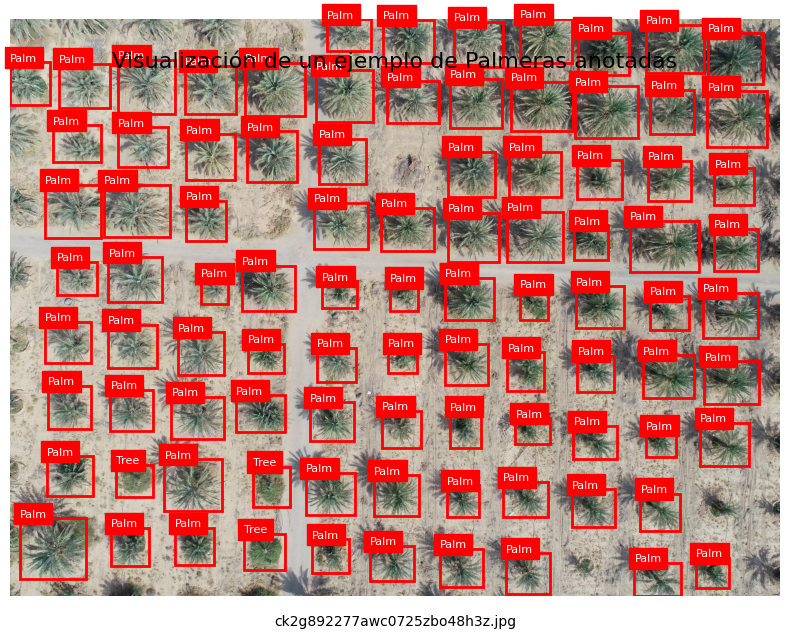

In [233]:
image_path, annotation_path = get_random_image_and_annotation(
    RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA, RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS
)
config = {
    "linewidth": 2,
    "edgecolor": "r",
    "facecolor": "none",
    "color": "white",
    "fontsize": 8,
    "backgroundcolor": "red",
    "putText": True,
    "show_image_name" : True,
    "name_fontsize" : 10,
    "super_title": "Visualización de un ejemplo de Palmeras anotadas",
    "super_title_fontsize": 16,
    "super_title_y": 0.8,
    "from_dataset_voc" : False,
}
show_single_image(image_path, annotation_path, config)

*Visualizamos también una grilla con varias imágenes y sus detecciones:*

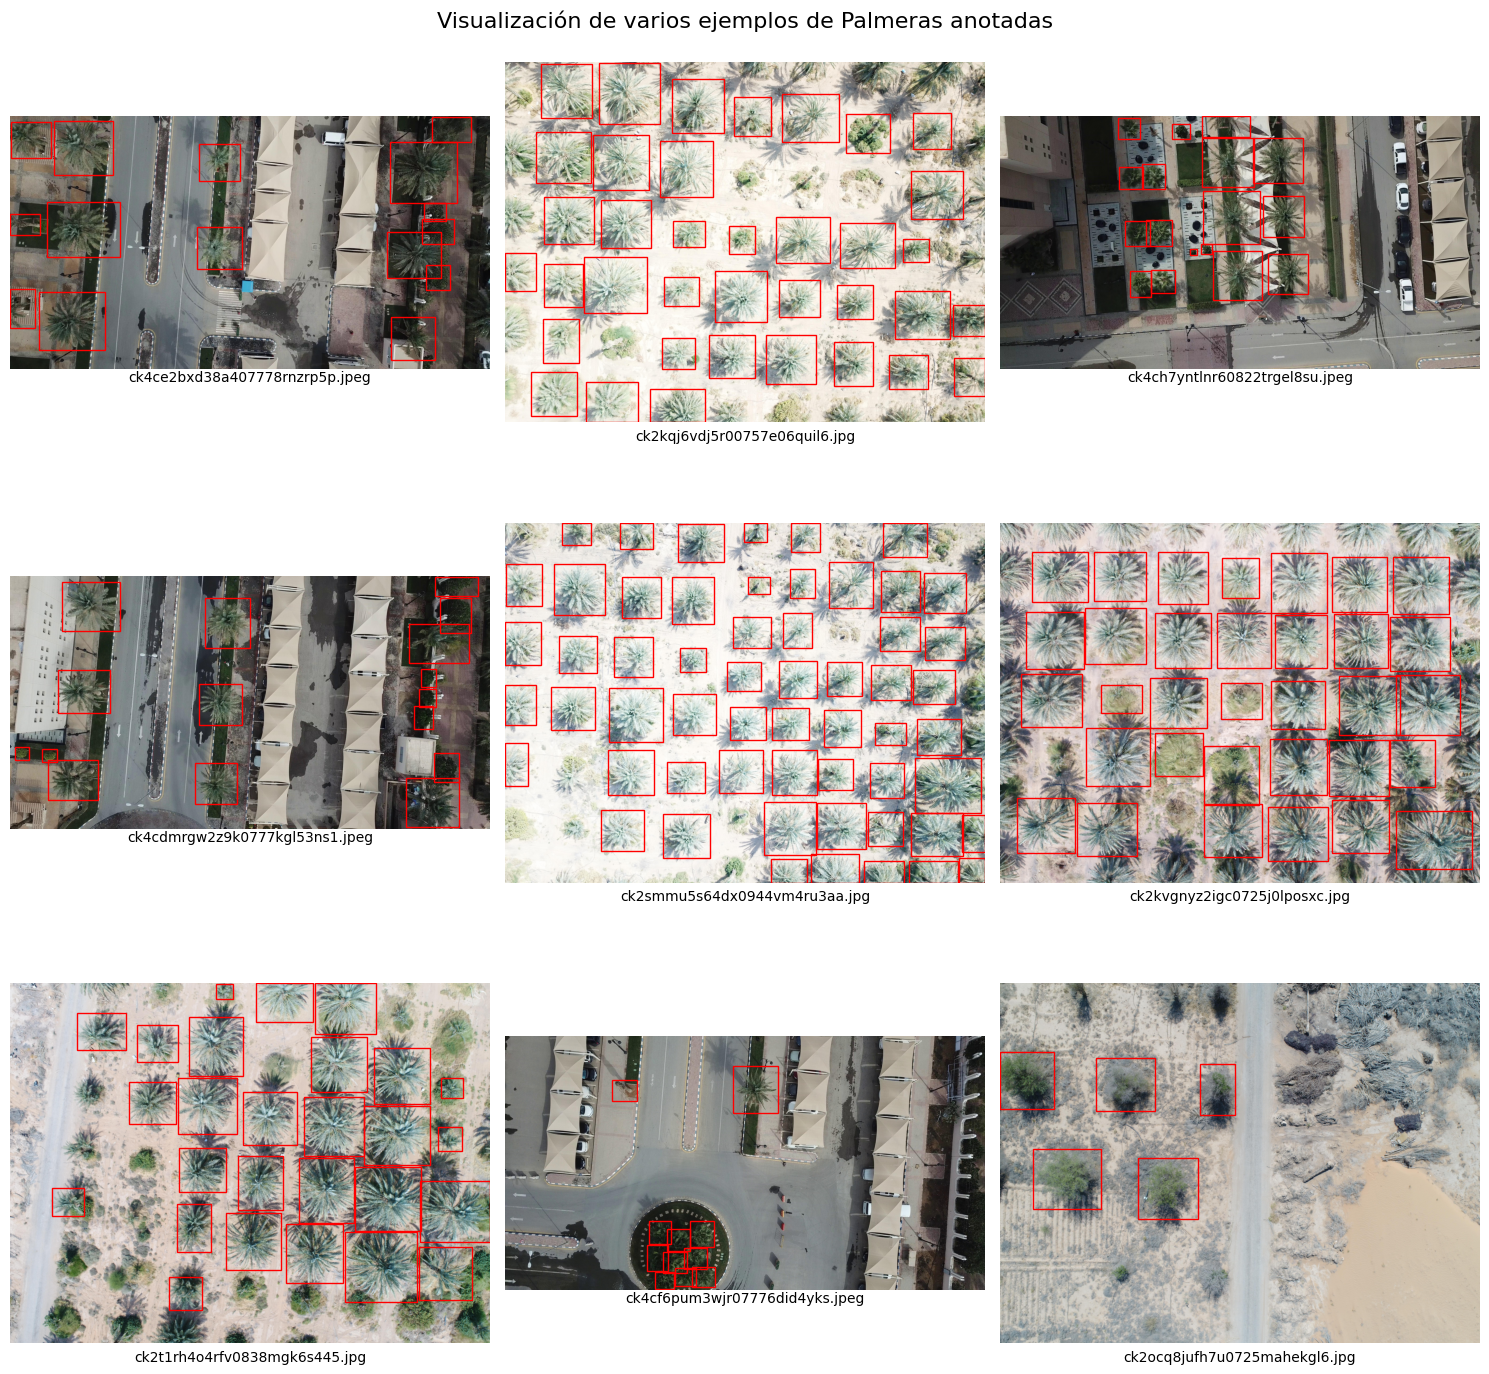

In [234]:
image_paths, annotation_paths = get_image_annotation_paths(RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA, RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS, max_files=9)
config = {
    "linewidth": 1,
    "edgecolor": "r",
    "facecolor": "none",
    "color": "white",
    "fontsize": 6,
    "backgroundcolor": "red",
    "putText": False,
    "show_image_name" : True,
    "name_fontsize" : 10,
    "super_title": "Visualización de varios ejemplos de Palmeras anotadas",
    "super_title_fontsize": 16,
    "super_title_y": 0.95,
    "from_dataset_voc" : False,
}
draw_grid(image_paths, annotation_paths, config)

También podemos utilizar la librería de FiftyOne (https://docs.voxel51.com/) para una mejor visualización. Otra ventaja de esta librería es que tiene un módulo de exportación a varios formatos conocidos:

In [14]:
# TODO: Investigar más esto.
# TODO: Arreglar annotaciones, es posible con esto?
# Crear el dataset en FiftyOne desde un formato PascalVOC
fiftyone_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.VOCDetectionDataset,
    dataset_dir=RUTA_CARPETA_KAGGLE_DATASET_VOC
)

 100% |█████████████████| 349/349 [16.8s elapsed, 0s remaining, 46.7 samples/s]      


Podemos observar los datos del conjunto:

In [15]:
print(fiftyone_dataset)

Name:        2024.10.10.15.15.41
Media type:  image
Num samples: 349
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)



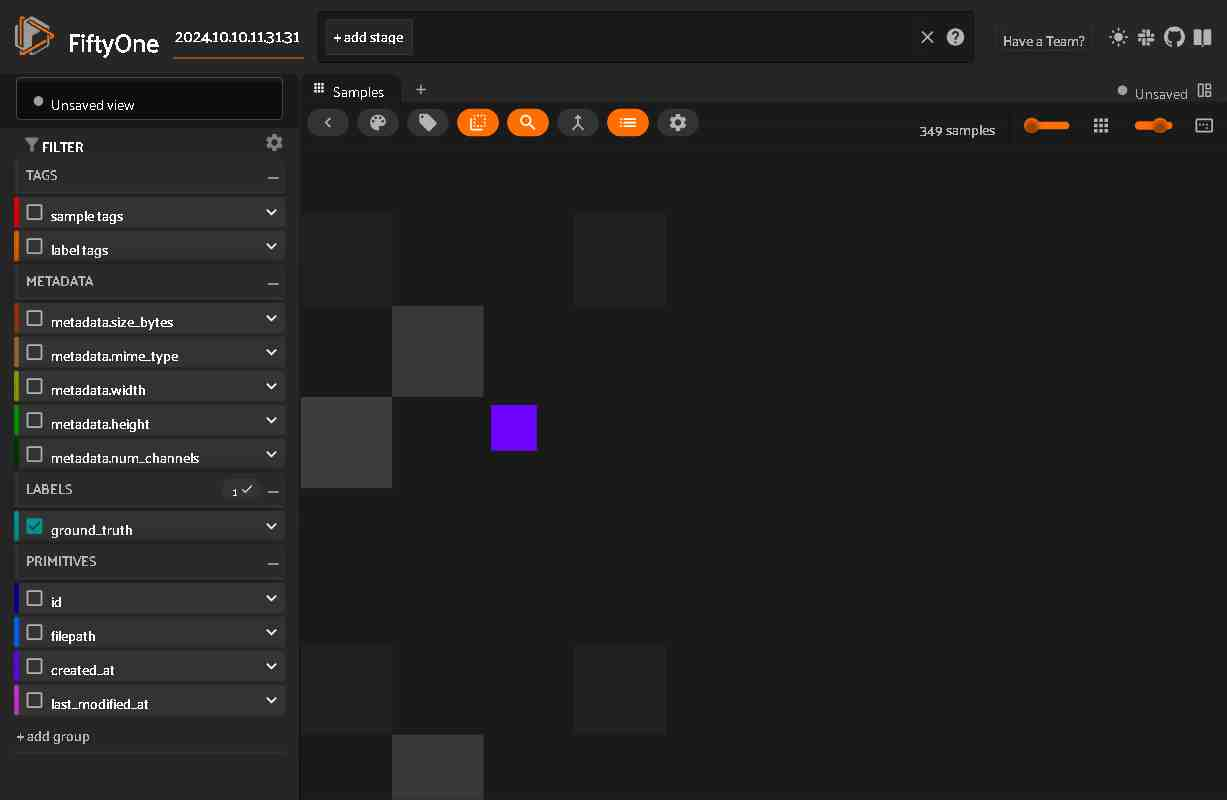

<IPython.core.display.Javascript object>

In [104]:
# TODO: Mejorar esta imagen, está cargando antes de tiempo... Poner un sleep?
# Lanzar la aplicación FiftyOne desde Jupyter
session = fo.launch_app(fiftyone_dataset)

session.freeze()
session.open_tab()

<!-- TODO: Balance de clases? Análisis de datos? -->

*La ventaja de utilizar FiftyOne, es que se puede exportar a varios formatos admitidos (https://docs.voxel51.com/user_guide/export_datasets.html | https://docs.voxel51.com/user_guide/export_datasets.html#custom-dataset-exporter). Como ejemplo, para exportar al formato de COCO sería:*

```python
fiftyone_dataset.export(
    export_dir=RUTA_CARPETA_KAGGLE_DATASET_COCO,
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth",
)
```

## Machine learning model engineering

*Como experimentos, dado que inicialmente el modelo no tiene como objetivo el funcionamiento en tiempo real, se plantea utilizar modelos de detección en dos etapas (ej: Faster R-CNN). Sin embargo, también se tienen en cuenta modelos de una sola etapa (ej: YOLO)*

### Faster R-CNN

<!-- TODO: Poner una introduccción y una imagen. -->

#### Preparar el datset

*En el formato actual del conjunto, es necesario generar una clase Dataset Customizada para el entrenamiento. Para eso podemos tomar como ejemplo este tutorial: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html*

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>

Para entrenar la red Faster R-CNN, es necesario que se cumplan algunos requerimientos, entre los cuales se encuentra una definición de la estructura del Dataset como la siguiente:

<cite>
The only specificity that we require is that the dataset __getitem__ should return a tuple:

- image: torchvision.tv_tensors.Image of shape [3, H, W], a pure tensor, or a PIL Image of size (H, W)
- target: a dict containing the following fields
    - `boxes`, torchvision.tv_tensors.BoundingBoxes of shape [N, 4]: the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
    - `labels`, integer torch.Tensor of shape [N]: the label for each bounding box. 0 represents always the background class.
    - `image_id`, int: an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    - `area`, float torch.Tensor of shape [N]: the area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    - `iscrowd`, uint8 torch.Tensor of shape [N]: instances with iscrowd=True will be ignored during evaluation.
    - (optionally) `masks`, torchvision.tv_tensors.Mask of shape [N, H, W]: the segmentation masks for each one of the objects

</cite>

También destacar que el modelo considera a la clase 0 como el fondo, lo que implica consideración en las labels

</p></font></em>

*Primero creamos el conjunto personalizado sin las transformaciones:*

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>En la creación de este conjunto, hay varias matices, entre las cuales se encuentra el tratamiento de ejemplos que no tienen ninguna detección.</p></font></em>

In [235]:
class PalmTreeDataset(Dataset):
    """Clase que crea el dataset partiendo de las imágenes en las carpetas data y labels"""
    def __init__(self, data_dir, labels_dir):
        self.data_dir = data_dir
        self.labels_dir = labels_dir
        self.imgs = list(sorted(os.listdir(data_dir)))
        self.labels = list(sorted(os.listdir(labels_dir)))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Cargar imagen
        img_path = os.path.join(self.data_dir, self.imgs[idx])
        label_path = os.path.join(self.labels_dir, self.labels[idx])
        img = read_image(img_path)

        # Parsear archivo XML (PascalVOC)
        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []
        isCrowd = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            if label in LABELS.keys():
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(LABELS[label])  # Hay solo una clase: Palmera
                isCrowd.append(0)  # Seteamos como falso.

        # Convertimos a tensores
        # Tratamiento de cuando no hay detecciones.
        if len(boxes) > 0:
            boxes = tv_tensors.BoundingBoxes(
                boxes, format="XYXY", canvas_size=F.get_image_size(img)
            )
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            # No hay ningún objeto detectado.
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            area = torch.tensor([], dtype=torch.float32)

        # Convertir el nombre del archivo a un número basado en los caracteres
        image_id = idx
        isCrowd = torch.as_tensor(isCrowd, dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = isCrowd
        target["img_path"] = img_path

        return img, target

*Creamos un conjunto de más alto rango que aplique las transformaciones. Estas transformaciones se aplican de este modo para separar con anterioridad al conjunto de train/test.*

In [236]:
class TransformedPalmTreeDataset(Dataset):
    """Clase de más alto rango que aplica las transofrmaciones al PalmsDataset"""
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

#### Definir las transformaciones

*Definimos las trasformaciones genéricas y las aumentaciones de datos al conjunto de train:*

In [237]:
def get_transforms(train):
    transforms = []
    if train:
        # TODO: Train augmentantions
        pass
    transforms.append(T.Resize(size=800))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

*Creamos los datasets:*

In [238]:
# Creamos el dataset
full_dataset = PalmTreeDataset(RUTA_CARPETA_KAGGLE_DATASET_VOC_DATA, RUTA_CARPETA_KAGGLE_DATASET_VOC_LABELS)

# Lo dividimos en train/test
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, TRAIN_TEST_SPLIT_RATIO, torch.Generator().manual_seed(RANDOM_SEED))

# Aplicamos las transformaciones.
train_dataset = TransformedPalmTreeDataset(train_dataset, transforms=get_transforms(train=True))
test_dataset = TransformedPalmTreeDataset(test_dataset, transforms=get_transforms(train=False))

*Visualizamos las transformaciones:*

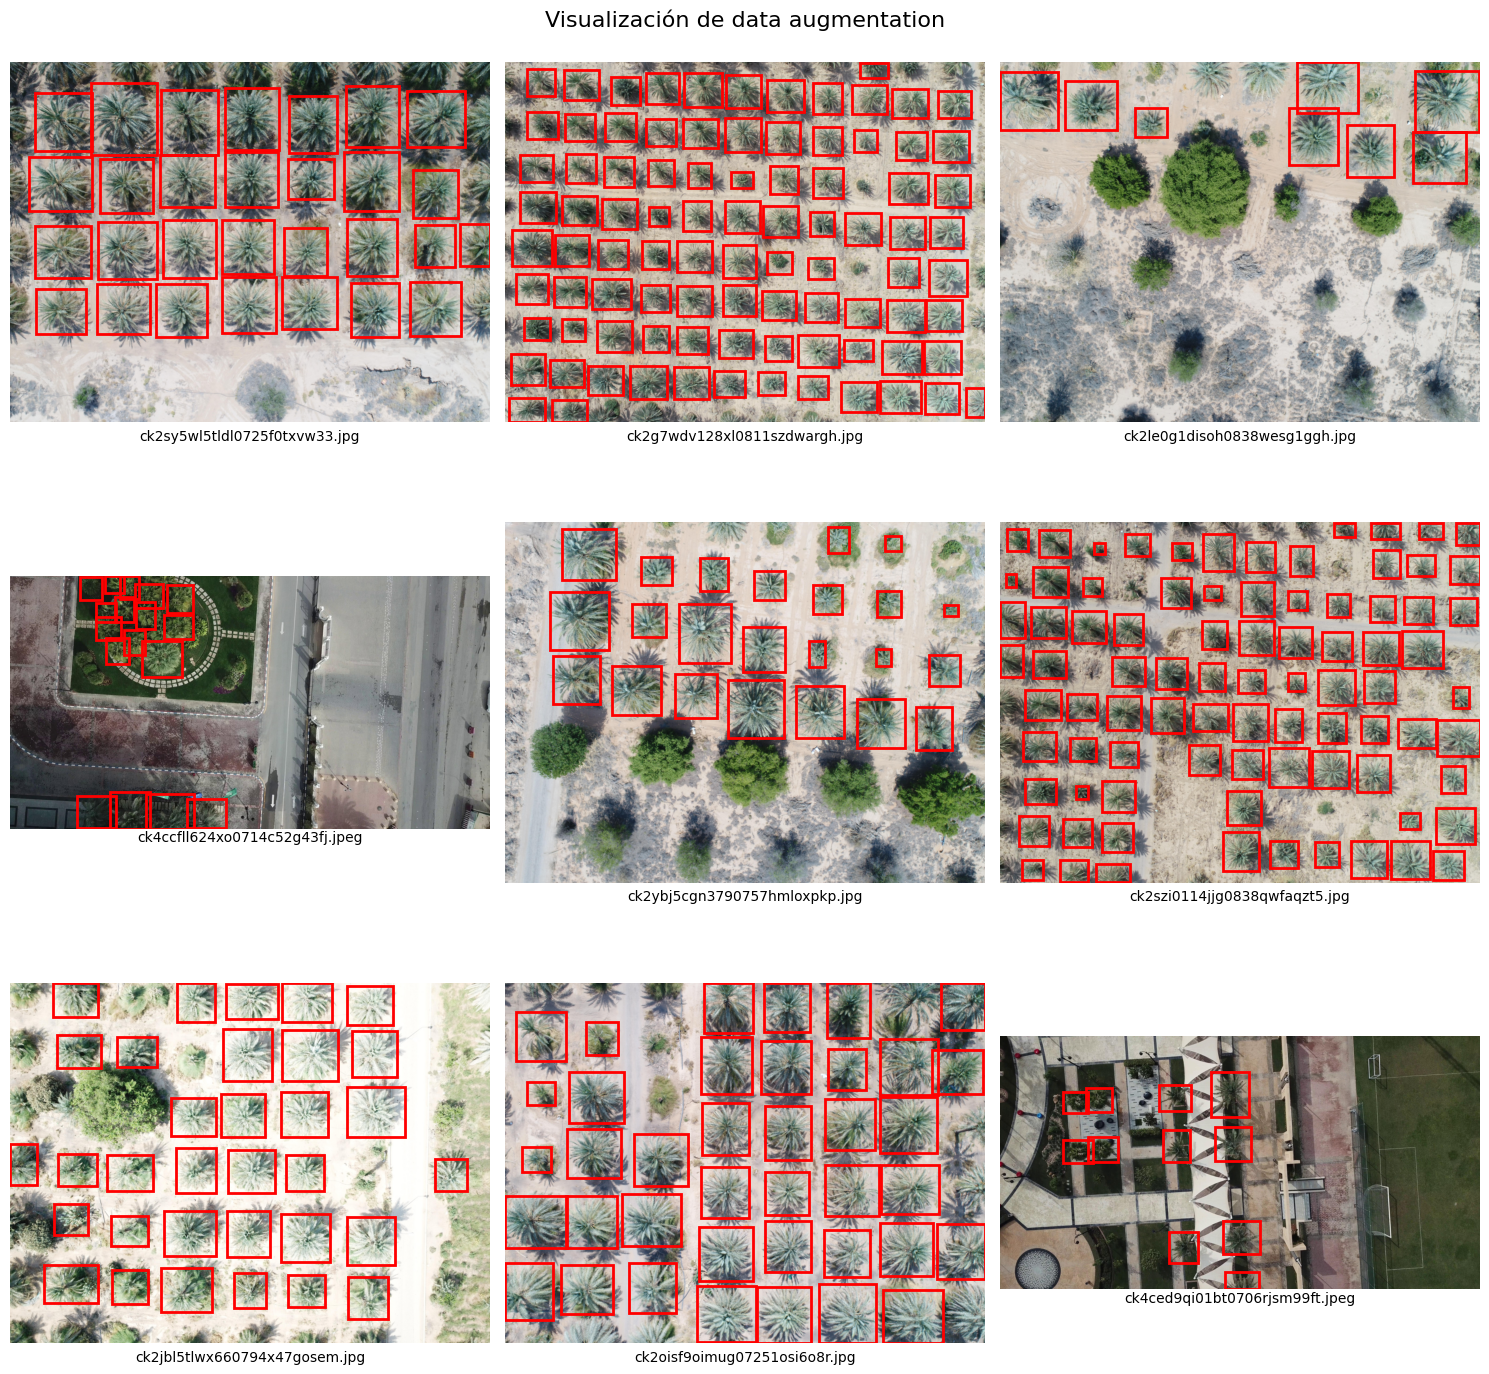

In [239]:
config = {
    "linewidth": 2,
    "edgecolor": "r",
    "facecolor": "none",
    "color": "white",
    "fontsize": 6,
    "backgroundcolor": "red",
    "putText": False,
    "show_image_name": True,
    "name_fontsize": 10,
    "super_title": "Visualización de data augmentation",
    "super_title_fontsize": 16,
    "super_title_y": 0.95,
    "from_dataset_voc": True,
}

draw_grid(
    [train_dataset[i][0] for i in range(9)],
    [train_dataset[i][1] for i in range(9)],
    config,
)

#### Definición del modelo

*Utilizaremos el modelo pre-entrando en el dataset de COCO (https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html#torchvision.models.detection.fasterrcnn_resnet50_fpn_v2). Primero, observamos como está compuesto el modelo para cambiar las capas correspondientes para nuestro caso:*

In [240]:
preview_model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
print(preview_model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

*Como haermos fine-tuning de este modelo, lo único que debemos cambiar es las últmas capas:*

```python
(box_predictor): FastRCNNPredictor(
      (cls_score): Linear(in_features=1024, out_features=91, bias=True)
      (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
    )
```

*Definimos una función especial para esto, en donde se le pasa el número de clases que debe predecir.*

In [241]:
def get_model(num_classes: int) -> torch.nn.Module:
    # Cargar un modelo preentrenado de Faster R-CNN (los pesos de coco)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    
    # Obtener el número de entradas de la capa de clasificación
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Reemplazar la cabeza del clasificador por una que tenga el número de clases deseado (n clase + fondo)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes + 1)
    
    return model

*Finalmente, instanciamos el modelo y vemos si efectivamente se cambiaron las últimas capas:*

In [242]:
# Instanciamos el modelo.
model = get_model(len(LABELS.keys()))
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

*Podemos observar un resumen del mismo mediante `torchinfo`:*

In [243]:
img, _ = train_dataset[0]
input_size = (1, *img.shape)
summary(model, input_size=input_size)

Layer (type:depth-idx)                             Output Shape              Param #
FasterRCNN                                         [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                    [1, 3, 800, 1088]         --
├─BackboneWithFPN: 1-2                             [1, 256, 13, 17]          --
│    └─IntermediateLayerGetter: 2-1                [1, 2048, 25, 34]         --
│    │    └─Conv2d: 3-1                            [1, 64, 400, 544]         (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 400, 544]         (128)
│    │    └─ReLU: 3-3                              [1, 64, 400, 544]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 200, 272]         --
│    │    └─Sequential: 3-5                        [1, 256, 200, 272]        (215,808)
│    │    └─Sequential: 3-6                        [1, 512, 100, 136]        1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 50, 68]         7,098,368
│    │

*Para comprobar el funcionamiento del modelo, podemos realizar un test de la inferencia y el entrenamiento:*

In [244]:
data_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)

# Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Devuelve losses y detections
print(f"Training test: {output}")

# Inferencia
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(f"Inference test: {predictions}")

Training test: {'loss_classifier': tensor(0.5383, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1262, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2302, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0246, grad_fn=<DivBackward0>)}
Inference test: [{'boxes': tensor([[0.0000e+00, 3.9645e+01, 1.2469e+02, 2.3903e+02],
        [2.8693e+02, 1.1089e+02, 3.0673e+02, 1.6610e+02],
        [0.0000e+00, 5.1714e+00, 2.1486e+01, 2.8968e+02],
        [0.0000e+00, 1.2160e+02, 1.5166e+02, 2.9143e+02],
        [0.0000e+00, 5.0687e+01, 3.8676e+01, 2.8240e+02],
        [2.9315e+02, 1.0943e+02, 3.1847e+02, 1.3743e+02],
        [1.6453e+01, 2.0480e+02, 2.1223e+02, 2.8695e+02],
        [0.0000e+00, 9.1299e+01, 8.4884e+00, 2.9108e+02],
        [0.0000e+00, 2.1850e+02, 5.1954e+01, 2.8245e+02],
        [0.0000e+00, 1.1043e+02, 6.7081e+01, 2.9310e+02],
        [0.0000e+00, 1.8298e+02, 3.7239e+00, 2.9333e+02],
        [2.3084e+02, 5.0250e+01, 2.4901e+02, 1.0293e+02]

#### Preparar el entrenamiento

*Una vez que tenemos probado el funcionamiento del modelo, realizamos las pre-paraciones previas al entrenamiento:*

In [245]:
# TODO: Borrar esto
from torch.utils.data import RandomSampler, DataLoader, Subset
train_dataset = Subset(train_dataset, np.arange(2))
test_dataset = Subset(test_dataset, np.arange(1))
EPOCHS = 5 # Cantidad de épocas genéricas a entrenar.
BATCH_SIZE = 1 # Tamaño de batch genérico.
print(len(train_dataset), len(test_dataset))

2 1


In [246]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Enviar modelo a GPU si está disponible
model.to(DEVICE)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Aprender tasa de aprendizaje (LR) programada
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#### Entrenar el modelo

In [247]:
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_dataloader, DEVICE, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, test_dataloader, DEVICE)

d:\Documentos\Git Repositories\uba-ceia\ceia-vpc2\resources\utils\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [0/2]  eta: 0:01:14  lr: 0.005000  loss: 4.1436 (4.1436)  loss_classifier: 0.6444 (0.6444)  loss_box_reg: 0.5109 (0.5109)  loss_objectness: 2.9050 (2.9050)  loss_rpn_box_reg: 0.0832 (0.0832)  time: 37.4855  data: 0.3643
Epoch: [0]  [1/2]  eta: 0:00:33  lr: 0.005000  loss: 3.4681 (3.8058)  loss_classifier: 0.6250 (0.6347)  loss_box_reg: 0.4030 (0.4570)  loss_objectness: 2.2871 (2.5960)  loss_rpn_box_reg: 0.0832 (0.1181)  time: 33.4509  data: 0.3506
Epoch: [0] Total time: 0:01:06 (33.4805 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:11  model_time: 11.2916 (11.2916)  evaluator_time: 0.3033 (0.3033)  time: 11.7413  data: 0.1424
Test: Total time: 0:00:11 (11.7433 s / it)
Averaged stats: model_time: 11.2916 (11.2916)  evaluator_time: 0.3033 (0.3033)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets

#### Verificacion de resultados

#### Prueba de inferencia

### YOLO

Para el caso de una capa, se utiliza YOLOv8.

El formato de una etiqueta de YOLOv8 es: ``<class_id> <x_center> <y_center> <width> <height>``

In [ ]:
import pandas as pd
import os

In [ ]:
# Archivo YAML de configuración
YOLO_CONFIG_YAML = './resources/utils/yolov8_palmeras.yaml'

RUTA_CARPETA_YOLO = './resources/datasets/raw/palmeras_kaggle/yolo'
RUTA_CARPETA_YOLO_UNZIP = os.path.join(RUTA_CARPETA_YOLO, 'Palm-Counting-349images')
RUTA_CARPETA_YOLO_TRAIN = os.path.join(RUTA_CARPETA_YOLO, 'train')
RUTA_CARPETA_YOLO_TEST = os.path.join(RUTA_CARPETA_YOLO, 'test')

# Paths a los archivos CSV
TRAIN_CSV_PATH = os.path.join(RUTA_CARPETA_YOLO_UNZIP, 'train_labels.csv')
TEST_CSV_PATH = os.path.join(RUTA_CARPETA_YOLO_UNZIP, 'test_labels.csv')

# Etiquetas:
LABELS = {
    'Tree' : 0,
    'Palm' : 1
}

In [ ]:
# Crear la carpeta 'raw' si no existe
os.makedirs(RUTA_CARPETA_YOLO, exist_ok=True)

# Verificar si la carpeta compressed existe
if os.path.exists(RUTA_CARPETA_COMPRESSED):
    descomprimir_archivos(RUTA_CARPETA_COMPRESSED, RUTA_CARPETA_YOLO)
else:
    warnings.warn(f"La carpeta {RUTA_CARPETA_COMPRESSED} no fue encontrada. Verifique la estructura")

Descomprimiendo palmeras_kaggle.zip en ./resources/datasets/raw/palmeras_kaggle/yolo...
palmeras_kaggle.zip descomprimido exitosamente.


In [ ]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

# Se imprime el head de los dataframes para verificar que se cargaron correctamente
print(train_df.head())
print(test_df.head())

# Veamos las clases disponibles
print('--- Clases disponibles ---')
print('En Train: ', train_df['class'].unique())
print('En Test: ', test_df['class'].unique())

                        filename  width  height class  xmin  ymin  xmax  ymax
0  ck2oh0xx2sthb0838g3pmr4ky.jpg   4000    3000  Palm  1147  1694  1337  1863
1  ck2oh0xx2sthb0838g3pmr4ky.jpg   4000    3000  Palm  1392  1725  1567  1918
2  ck2oh0xx2sthb0838g3pmr4ky.jpg   4000    3000  Palm  1645  1816  1756  1933
3  ck2oh0xx2sthb0838g3pmr4ky.jpg   4000    3000  Palm  1913  1793  2104  1966
4  ck2oh0xx2sthb0838g3pmr4ky.jpg   4000    3000  Palm  2270  1817  2488  2034
                        filename  width  height class  xmin  ymin  xmax  ymax
0  ck2jfuaiwocqi07256rg8xca1.jpg   4864    3648  Tree  1978  1084  2349  1414
1  ck2jfuaiwocqi07256rg8xca1.jpg   4864    3648  Tree  2295  1947  2727  2465
2  ck2jfuaiwocqi07256rg8xca1.jpg   4864    3648  Tree  1358  1765  1912  2357
3  ck2jfuaiwocqi07256rg8xca1.jpg   4864    3648  Tree     0  2479   380  2981
4  ck2jfuaiwocqi07256rg8xca1.jpg   4864    3648  Tree  1664  2740  2268  3264
--- Clases disponibles ---
En Train:  ['Palm' 'Tree']
En Test:  

In [ ]:
# Función para convertir las coordenadas de las cajas de anotación a formato YOLO
def convert_to_yolo_format(row):
    try:
        image_width = row['width']
        image_height = row['height']
        x_center = (row['xmin'] + row['xmax']) / 2.0 / image_width
        y_center = (row['ymin'] + row['ymax']) / 2.0 / image_height
        width = (row['xmax'] - row['xmin']) / image_width
        height = (row['ymax'] - row['ymin']) / image_height
        class_id = LABELS.get(row['class'], None)
        if class_id is None:
            print(f"Clase no encontrada: <{row['class']}> en la fila <{row}>")
            return None
        return class_id, x_center, y_center, width, height
    except KeyError as e:
        print(f"Falta un dato en la fila: {e}")
        return None
    except TypeError:
        print("Datos invalidos encontrados.")
        return None

# Función para guardar las anotaciones en formato YOLO
def save_yolo_annotations(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for _, row in df.iterrows():
        yolo_data = convert_to_yolo_format(row)
        filename = os.path.splitext(row['filename'])[0] + '.txt'
        output_path = os.path.join(output_dir, filename)
        
        if yolo_data:
            with open(output_path, 'a') as f:
                f.write(f"{yolo_data[0]} {yolo_data[1]:.6f} {yolo_data[2]:.6f} {yolo_data[3]:.6f} {yolo_data[4]:.6f}\n")

In [ ]:
save_yolo_annotations(train_df, RUTA_CARPETA_YOLO_TRAIN)
save_yolo_annotations(test_df, RUTA_CARPETA_YOLO_TEST)

In [ ]:
# Define los paths de las carpetas
base_dir = os.path.join(RUTA_CARPETA_YOLO, "Palm-Counting-349images")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Renombrar la carpeta Palm-Counting-349images a palmeras_kaggle
if os.path.exists(base_dir):

    # Crea las nuevas carpetas si no existen
    os.makedirs(RUTA_CARPETA_YOLO_TRAIN, exist_ok=True)
    os.makedirs(RUTA_CARPETA_YOLO_TEST, exist_ok=True)

    # Mover archivos de train y test a las nuevas carpetas
    try:
        mover_archivos(
            train_dir,
            RUTA_CARPETA_YOLO_TRAIN,
            RUTA_CARPETA_YOLO_TRAIN,
            img_only=True,
        )
        mover_archivos(
            test_dir,
            RUTA_CARPETA_YOLO_TEST,
            RUTA_CARPETA_YOLO_TEST,
            img_only=True,
        )
    except:
        warnings.warn(
            f"Error al mover los archivos. Las carpetas {train_dir} y {test_dir} existen? O ya fueron borradas?"
        )

    # Eliminar las carpetas de train y test
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    # Elimina los archivos .csv
    csv_files = ["train_labels.csv", "test_labels.csv"]
    for csv_file in csv_files:
        csv_path = os.path.join(base_dir, csv_file)
        if os.path.exists(csv_path):
            os.remove(csv_path)

    # Elimina la carpeta base
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)

    print(
        "Archivos movidos, archivos CSV eliminados y la carpeta renombrada correctamente."
    )

else:
    raise FileNotFoundError(f"No se descomprimió el dataset {base_dir}")

Archivos movidos, archivos CSV eliminados y la carpeta renombrada correctamente.


In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available


True


In [ ]:
from ultralytics import YOLO

# Se instancia el modelo YOLO v8 nano
model = YOLO("yolov8n.pt") 

# Se entrena el modelo
model.train(data=YOLO_CONFIG_YAML, epochs=100, imgsz=640, device=DEVICE, project='yolov8/runs/train', name='deteccion_palmeras_')

100%|██████████| 6.25M/6.25M [00:00<00:00, 11.4MB/s]


Ultralytics 8.3.9  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./resources/utils/yolov8_palmeras.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=yolov8/runs/train, name=deteccion_palmeras3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False,

100%|██████████| 5.35M/5.35M [00:00<00:00, 11.4MB/s]


AMP: checks passed 


train: Scanning D:\ProyectosUBA\CEIA\5_Vision_por_Computadora_II\repo_bruno\uba-ceia\ceia-vpc2\resources\datasets\raw\palmeras_kaggle\yolo\train... 279 images, 0 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<00:00, 518.66it/s]


train: New cache created: D:\ProyectosUBA\CEIA\5_Vision_por_Computadora_II\repo_bruno\uba-ceia\ceia-vpc2\resources\datasets\raw\palmeras_kaggle\yolo\train.cache


val: Scanning D:\ProyectosUBA\CEIA\5_Vision_por_Computadora_II\repo_bruno\uba-ceia\ceia-vpc2\resources\datasets\raw\palmeras_kaggle\yolo\test... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 359.07it/s]

val: New cache created: D:\ProyectosUBA\CEIA\5_Vision_por_Computadora_II\repo_bruno\uba-ceia\ceia-vpc2\resources\datasets\raw\palmeras_kaggle\yolo\test.cache


Plotting labels to yolov8\runs\train\deteccion_palmeras3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8\runs\train\deteccion_palmeras3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.46G      2.093      3.675      1.648        438        640: 100%|██████████| 18/18 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         70       2670     0.0727      0.481       0.16     0.0684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.88G       1.55      2.833      1.149        528        640: 100%|██████████| 18/18 [03:05<00:00, 10.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         70       2670      0.101      0.601      0.369      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.77G      1.569      1.959      1.134        435        640: 100%|██████████| 18/18 [00:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


                   all         70       2670     0.0979      0.541      0.325      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       3.7G      1.506      1.442      1.143        262        640: 100%|██████████| 18/18 [00:04<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         70       2670      0.114      0.593      0.345      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.34G      1.422      1.167      1.138        266        640: 100%|██████████| 18/18 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         70       2670      0.133      0.751      0.461      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.24G      1.414        1.1      1.122        204        640: 100%|██████████| 18/18 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         70       2670      0.629      0.382      0.515      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.38G      1.416       1.01      1.125        408        640: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


                   all         70       2670       0.63      0.547      0.576        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.65G      1.367     0.9549      1.098        477        640: 100%|██████████| 18/18 [00:17<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         70       2670      0.601      0.557      0.596        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.48G      1.346      0.925      1.096        449        640: 100%|██████████| 18/18 [00:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         70       2670       0.61      0.586      0.619       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.64G      1.326      0.879      1.092        383        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

                   all         70       2670      0.705      0.646      0.695      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.87G      1.324      0.853      1.096        427        640: 100%|██████████| 18/18 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         70       2670      0.638      0.626      0.669      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.72G      1.322     0.8324      1.088        274        640: 100%|██████████| 18/18 [00:03<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         70       2670       0.75      0.641      0.693      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.71G      1.342     0.8314      1.093        532        640: 100%|██████████| 18/18 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         70       2670      0.668      0.698      0.715      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.72G      1.338     0.8033      1.084        287        640: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         70       2670      0.696      0.679      0.704      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.1G      1.324     0.8228      1.084        386        640: 100%|██████████| 18/18 [00:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         70       2670      0.742      0.706      0.744      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.98G      1.282     0.7809      1.077        537        640: 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         70       2670      0.713       0.72      0.736      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.72G      1.341     0.7713       1.09        366        640: 100%|██████████| 18/18 [00:03<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         70       2670      0.645       0.58      0.638      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.83G      1.325     0.7754      1.088        476        640: 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         70       2670      0.685      0.724      0.695      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.28G      1.316     0.7701      1.074        444        640: 100%|██████████| 18/18 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


                   all         70       2670      0.732      0.695      0.731      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.94G      1.274     0.7366      1.078        423        640: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         70       2670      0.715      0.712      0.743      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.06G      1.283     0.7247      1.079        379        640: 100%|██████████| 18/18 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         70       2670      0.725      0.752      0.754      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.93G      1.268     0.7268      1.072        634        640: 100%|██████████| 18/18 [00:03<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         70       2670      0.734       0.75       0.76      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.27G       1.26     0.7065      1.061        520        640: 100%|██████████| 18/18 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


                   all         70       2670      0.729      0.767      0.772      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.55G      1.233     0.7116      1.063        351        640: 100%|██████████| 18/18 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


                   all         70       2670      0.716      0.722      0.735      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.19G      1.245     0.7084       1.07        454        640: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


                   all         70       2670      0.765      0.793      0.818      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.13G      1.249     0.6985       1.05        441        640: 100%|██████████| 18/18 [00:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         70       2670      0.772      0.759      0.785      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.36G       1.25     0.6992      1.059        538        640: 100%|██████████| 18/18 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         70       2670      0.699      0.793      0.759      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.27G      1.237     0.6898      1.065        373        640: 100%|██████████| 18/18 [00:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         70       2670       0.72      0.769      0.768      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.49G      1.236     0.6788      1.052        387        640: 100%|██████████| 18/18 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


                   all         70       2670      0.766      0.732      0.776      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.93G       1.25     0.6893      1.055        568        640: 100%|██████████| 18/18 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         70       2670      0.777      0.756      0.783      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.77G      1.234     0.6713      1.052        272        640: 100%|██████████| 18/18 [00:03<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         70       2670      0.768      0.787      0.798      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.91G      1.228     0.6708      1.065        362        640: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         70       2670      0.747      0.743      0.747       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.75G      1.211     0.6659      1.053        374        640: 100%|██████████| 18/18 [00:03<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         70       2670      0.825      0.722      0.801      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.26G      1.257     0.6712      1.055        434        640: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         70       2670      0.765      0.756      0.782      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.19G      1.241     0.6659      1.043        524        640: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


                   all         70       2670      0.746      0.779      0.783      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.85G      1.235     0.6513      1.052        306        640: 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         70       2670      0.742      0.767      0.779      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.33G      1.236     0.6644      1.059        322        640: 100%|██████████| 18/18 [00:03<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         70       2670      0.798      0.755      0.795      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.92G       1.24     0.6505      1.055        347        640: 100%|██████████| 18/18 [00:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         70       2670      0.769      0.765      0.786      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.97G      1.227     0.6525      1.054        438        640: 100%|██████████| 18/18 [00:03<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         70       2670       0.78       0.79      0.804      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.17G      1.211     0.6353      1.052        433        640: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         70       2670      0.798      0.768      0.806      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.93G      1.204     0.6337      1.043        384        640: 100%|██████████| 18/18 [00:03<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         70       2670      0.764      0.782      0.807      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.48G      1.229     0.6529      1.055        343        640: 100%|██████████| 18/18 [00:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


                   all         70       2670      0.773      0.769      0.791      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       3.9G       1.22     0.6427      1.055        419        640: 100%|██████████| 18/18 [00:03<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         70       2670      0.791       0.76      0.799      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.62G      1.215      0.632      1.041        620        640: 100%|██████████| 18/18 [00:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         70       2670       0.75      0.771      0.776      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.43G      1.174     0.6115      1.034        497        640: 100%|██████████| 18/18 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         70       2670      0.776      0.774      0.793      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.66G      1.211     0.6287      1.045        539        640: 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         70       2670      0.773      0.792      0.802      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.08G      1.197     0.6211      1.046        293        640: 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


                   all         70       2670      0.774      0.798      0.799      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.39G      1.183     0.6181      1.042        352        640: 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         70       2670      0.764      0.771      0.784      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.46G      1.179     0.6119      1.041        541        640: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         70       2670       0.79      0.774      0.811      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.08G      1.214     0.6321      1.047        407        640: 100%|██████████| 18/18 [00:03<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         70       2670      0.783      0.777      0.797       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.41G      1.191     0.6088      1.046        496        640: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         70       2670      0.767      0.784      0.789      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.91G      1.191     0.6043      1.035        465        640: 100%|██████████| 18/18 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


                   all         70       2670      0.765       0.78      0.791      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.96G      1.194     0.6015      1.041        553        640: 100%|██████████| 18/18 [00:03<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         70       2670      0.763      0.765      0.777      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.13G       1.16     0.6032      1.036        449        640: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         70       2670      0.774      0.765      0.791      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.63G      1.175     0.5983      1.038        262        640: 100%|██████████| 18/18 [00:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         70       2670      0.786      0.789      0.806       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.69G      1.163     0.5845      1.025        475        640: 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


                   all         70       2670      0.797      0.796      0.813      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.11G      1.167     0.6046      1.044        252        640: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


                   all         70       2670      0.796      0.785      0.814      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.24G      1.167     0.5943      1.031        550        640: 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


                   all         70       2670      0.801      0.757      0.801      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.72G       1.17     0.6012      1.033        315        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.49s/it]

                   all         70       2670      0.748      0.802      0.786       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.5G      1.162     0.5909      1.036        474        640: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

                   all         70       2670      0.762      0.791      0.782      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.94G      1.178     0.5869      1.021        549        640: 100%|██████████| 18/18 [00:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         70       2670      0.784      0.757      0.792       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.09G      1.173       0.59      1.039        360        640: 100%|██████████| 18/18 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         70       2670      0.793      0.768        0.8      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.03G      1.156     0.5778      1.029        473        640: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         70       2670      0.737      0.811      0.783      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.66G      1.169     0.5771      1.028        395        640: 100%|██████████| 18/18 [00:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         70       2670      0.785      0.777      0.807      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.45G       1.15     0.5733      1.024        511        640: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70       2670      0.783      0.793      0.808      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.52G       1.16     0.5825      1.032        411        640: 100%|██████████| 18/18 [00:03<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         70       2670      0.776      0.789      0.783      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.81G      1.125     0.5582      1.031        449        640: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


                   all         70       2670      0.787      0.793      0.794      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.68G      1.181     0.5833      1.034        394        640: 100%|██████████| 18/18 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         70       2670      0.791      0.793      0.807      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.75G      1.159     0.5742       1.03        424        640: 100%|██████████| 18/18 [00:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         70       2670      0.779      0.794      0.801       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.76G      1.136     0.5652      1.026        307        640: 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


                   all         70       2670      0.778      0.791      0.802       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.44G      1.123     0.5531      1.023        504        640: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         70       2670       0.77      0.793       0.79      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.15G      1.168     0.5779      1.037        320        640: 100%|██████████| 18/18 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         70       2670       0.78      0.806      0.805      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.05G       1.14     0.5623      1.023        497        640: 100%|██████████| 18/18 [00:03<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         70       2670      0.795      0.771      0.803      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.94G      1.111     0.5473      1.008        548        640: 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         70       2670      0.802      0.789      0.821      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.51G      1.132     0.5571      1.013        667        640: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         70       2670      0.809      0.775      0.813      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.79G      1.131     0.5565      1.016        537        640: 100%|██████████| 18/18 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


                   all         70       2670      0.792      0.803      0.814      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.25G      1.121     0.5497      1.021        468        640: 100%|██████████| 18/18 [00:03<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         70       2670      0.803      0.785      0.807      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.28G      1.121     0.5442      1.007        520        640: 100%|██████████| 18/18 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


                   all         70       2670      0.783      0.791      0.804      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       3.8G      1.109     0.5454      1.012        649        640: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         70       2670      0.788      0.783      0.806      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.14G      1.123     0.5522      1.027        302        640: 100%|██████████| 18/18 [00:03<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         70       2670      0.774      0.802      0.809       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.55G      1.106     0.5364      1.011        372        640: 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         70       2670      0.785      0.799      0.811      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.57G      1.108     0.5395       1.02        439        640: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


                   all         70       2670      0.793       0.81      0.813      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.67G      1.106     0.5413      1.006        445        640: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

                   all         70       2670       0.78      0.824      0.811      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.39G      1.095     0.5395      1.006        717        640: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         70       2670      0.793      0.805      0.816      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.38G      1.107     0.5374      1.009        495        640: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         70       2670      0.783      0.801      0.814      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.01G      1.115     0.5399       1.01        367        640: 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         70       2670      0.811      0.799      0.814      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.44G      1.101     0.5333      1.008        361        640: 100%|██████████| 18/18 [00:03<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         70       2670       0.79      0.805      0.818      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.44G      1.102     0.5302      1.009        477        640: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


                   all         70       2670      0.786      0.821      0.817      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       4.3G      1.102     0.5395      1.015        277        640: 100%|██████████| 18/18 [00:03<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


                   all         70       2670      0.776      0.814      0.814      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.56G       1.09     0.5295      1.008        372        640: 100%|██████████| 18/18 [00:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         70       2670      0.779       0.82      0.813      0.452


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.01G      1.134     0.5826      1.038        254        640: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         70       2670       0.77        0.8      0.793      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.66G      1.096     0.5457      1.019        280        640: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         70       2670       0.74      0.801      0.793      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.78G      1.089     0.5261      1.012        291        640: 100%|██████████| 18/18 [00:03<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         70       2670       0.77       0.79      0.801       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.77G      1.082     0.5268      1.003        199        640: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         70       2670      0.768      0.814      0.806      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.72G      1.065     0.5136      1.006        242        640: 100%|██████████| 18/18 [00:03<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         70       2670      0.796      0.774      0.802      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.65G      1.071     0.5227      1.008        287        640: 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


                   all         70       2670      0.786      0.801       0.81      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.06G      1.067     0.5123      1.006        205        640: 100%|██████████| 18/18 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all         70       2670      0.773       0.81       0.81      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.96G       1.06     0.5125      1.006        190        640: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


                   all         70       2670      0.786       0.81      0.817      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.96G      1.045     0.5011     0.9955        237        640: 100%|██████████| 18/18 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         70       2670      0.782       0.81      0.816      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.24G      1.058     0.5115      1.008        217        640: 100%|██████████| 18/18 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         70       2670       0.78      0.818      0.817      0.448



100 epochs completed in 0.245 hours.
Optimizer stripped from yolov8\runs\train\deteccion_palmeras3\weights\last.pt, 5.6MB
Optimizer stripped from yolov8\runs\train\deteccion_palmeras3\weights\best.pt, 5.6MB

Validating yolov8\runs\train\deteccion_palmeras3\weights\best.pt...
Ultralytics 8.3.9  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 186 layers, 2,684,758 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


                   all         70       2670      0.804      0.791      0.822      0.455
                  Tree         43        325      0.688      0.631      0.672      0.299
                  Palm         66       2345       0.92      0.951      0.971      0.611
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to yolov8\runs\train\deteccion_palmeras3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002B0DF7CC5D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

#### Verificación de Resultados

In [ ]:
# Se realiza la evaluación del modelo entrenado
metrics = model.val(data=YOLO_CONFIG_YAML, imgsz=640, device=DEVICE)
print(metrics)

Ultralytics 8.3.9  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 186 layers, 2,684,758 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning D:\ProyectosUBA\CEIA\5_Vision_por_Computadora_II\repo_bruno\uba-ceia\ceia-vpc2\resources\datasets\raw\palmeras_kaggle\yolo\test.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


                   all         70       2670        0.8      0.794      0.822      0.453
                  Tree         43        325      0.681      0.638      0.673      0.298
                  Palm         66       2345      0.919      0.951      0.971      0.609
Speed: 0.7ms preprocess, 7.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to yolov8\runs\train\deteccion_palmeras32
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002B0DB5019D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.

#### Inferencia

In [ ]:
# Load the best model after training
inf_model = YOLO('yolov8/runs/train/deteccion_palmeras3/weights/best.pt')  # Path to the best weights

IMAGENES_PARA_INFERENCIA_PATH = 'resources/datasets/raw/palmeras_kaggle/yolo/inferencia/'
RESULTADOS_INFERENCIA_PATH = IMAGENES_PARA_INFERENCIA_PATH

# Run inference on a new image
set_imagenes = ['mvd_001.jpg']
results = inf_model(IMAGENES_PARA_INFERENCIA_PATH + 'inf_*.jpg', classes=[1])

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    # result.save(filename=RESULTADOS_INFERENCIA_PATH)  # save to disk


## Referencias

- Adel Ammar, and Anis Koubaa. (2023). Aerial images of palm trees [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6382990
- TorchVision Object Detection Finetuning Tutorial — PyTorch Tutorials 2.4.0+cu121 documentation. (n.d.). https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html